# A first example
This is a first example of how to use lettuce.
A two dimensional Taylor Green vortex is initialized and simulated for 10000 steps. Afterwards the energy and the velocity field is plotted.

In [18]:
import os
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import csv

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

In [19]:
lattice = lt.Lattice(lt.D3Q19, device = "cpu", dtype=torch.float64)
#flow = lt.ReducedTaylorGreenVortex2D(resolution=128, reynolds_number=1000, mach_number=0.05, lattice=lattice)
flow = lt.TaylorGreenVortex3D(resolution=32, reynolds_number=100, mach_number=0.05, lattice=lattice)
#print(flow.units.convert_time_to_lu(1))
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
#print(flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
#simulation = lt.SimulationReducedTGV(flow=flow, lattice=lattice, collision=collision, streaming=streaming)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

176.42524653497344
0.5044106311633744


* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [20]:
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=10, out=None)
reporter2 = lt.ObservableReporter(Dissipation,interval = 10, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=10, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=10, filename_base="./output"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy


## Run simulation

In [21]:
simulation.initialize_f_neq()
mlups = simulation.step(num_steps=int(flow.units.convert_time_to_lu(10)))
print("Performance in MLUPS:", mlups)
print(simulation.lattice.rho(simulation.f))



Performance in MLUPS: 2.910405728064008
tensor([[[[0.9993, 0.9992, 0.9992,  ..., 0.9992, 0.9992, 0.9993],
          [0.9993, 0.9993, 0.9993,  ..., 0.9992, 0.9993, 0.9993],
          [0.9994, 0.9994, 0.9994,  ..., 0.9994, 0.9994, 0.9994],
          ...,
          [0.9994, 0.9994, 0.9994,  ..., 0.9994, 0.9994, 0.9994],
          [0.9993, 0.9993, 0.9992,  ..., 0.9993, 0.9993, 0.9993],
          [0.9993, 0.9992, 0.9992,  ..., 0.9992, 0.9992, 0.9993]],

         [[0.9993, 0.9993, 0.9992,  ..., 0.9993, 0.9993, 0.9993],
          [0.9994, 0.9993, 0.9993,  ..., 0.9993, 0.9993, 0.9994],
          [0.9995, 0.9994, 0.9994,  ..., 0.9994, 0.9995, 0.9995],
          ...,
          [0.9995, 0.9995, 0.9994,  ..., 0.9994, 0.9994, 0.9995],
          [0.9994, 0.9993, 0.9993,  ..., 0.9993, 0.9993, 0.9994],
          [0.9993, 0.9993, 0.9993,  ..., 0.9992, 0.9993, 0.9993]],

         [[0.9994, 0.9994, 0.9994,  ..., 0.9994, 0.9994, 0.9994],
          [0.9995, 0.9995, 0.9994,  ..., 0.9994, 0.9994, 0.9995],
  

## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(177, 3)


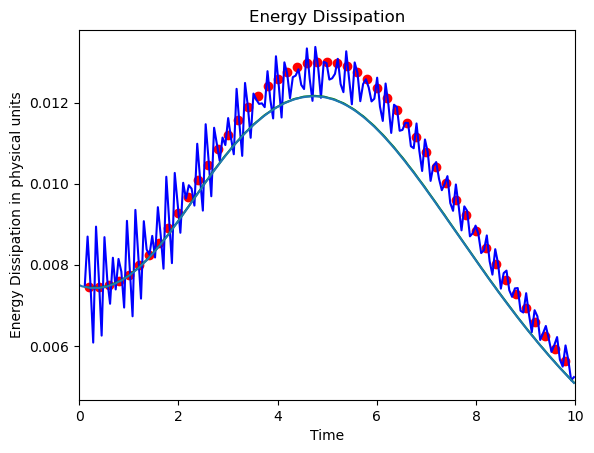

In [22]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)

save_directory = "/home/ben/Resultate Reduced TGV"
file_name = "FullTGV.pkl"
file_path = os.path.join(save_directory, file_name)
simulation.save_checkpoint(file_path)

csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re100.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

print(energy.shape)
csv_data = np.array(csv_data, dtype=float)
DisEkin=np.column_stack((energy[:,1],-1/(np.pi*2)**3*np.gradient(energy[:,2],energy[:,1])))

DisEns=np.column_stack((enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]))

DisSij=np.column_stack((dissipation[:,1],dissipation[:,2]))

#np.savetxt('/home/ben/Schreibtisch/ErgebnisseMP1/FullTGV/DisEns-Rey3000-Res64-BGK.csv',DisEns,delimiter=';')
#np.savetxt('/home/ben/Schreibtisch/ErgebnisseMP1/FullTGV/DisEkin-Rey3000-Res64-BGK.csv',DisEkin,delimiter=';')
#np.savetxt('/home/ben/Schreibtisch/ErgebnisseMP1/FullTGV/DisSij-Rey3000-Res64-BGK.csv',DisSij,delimiter=';')



#print(energy.shape)
#plt.plot(energy[:,1],energy[:,2])
#plt.plot(energy[5:-1,1],-1/((np.pi*2)**3)*np.diff(energy[5:,2])/np.diff(energy[5:,1]))
plt.plot(energy[2:,1],-1/(np.pi*2)**3*np.gradient(energy[2:,2],energy[2:,1]),color = 'blue')
plt.plot(dissipation[3:,1],dissipation[3:,2], color = 'green')
plt.xlim(0,10)
plt.plot(enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()



### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.